In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics 
import csv
import os
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from util.cliffsDelta import cliffsDelta
from datetime import datetime, timedelta, date
PROJS = ['tornadoweb/tornado', 'Netflix/eureka', 'ansible/awx', 'phpDocumentor/phpDocumentor2', 'processing/processing', 'neo4j/neo4j', 'doctrine/dbal', 'google/ExoPlayer', 'gevent/gevent', 'getredash/redash', 'pimcore/pimcore', 'kennethreitz/requests', 'alibaba/druid', 'vuejs/vue', 'novus/nvd3', 'osTicket/osTicket', 'splitbrain/dokuwiki', 'Dogfalo/materialize', 'pallets/flask', 'getpelican/pelican', 'nette/nette', 'jumpserver/jumpserver', 'keystonejs/keystone', 'caouecs/Laravel-lang', 'mitmproxy/mitmproxy', 'libgdx/libgdx', 'opencart/opencart', 'Atlantic18/DoctrineExtensions', 'aristath/kirki', 'howdyai/botkit', 'pixijs/pixi.js', 'hazelcast/hazelcast', 'pfsense/pfsense', 'ajaxorg/ace', 'dropbox/pyston', 'lra/mackup', 'TechEmpower/FrameworkBenchmarks', 'numba/numba', 'FriendsOfSymfony/FOSElasticaBundle', 'rtfd/readthedocs.org', 'spesmilo/electrum', 'openhab/openhab1-addons', 'select2/select2', 'atom/atom', 'Semantic-Org/Semantic-UI', 'wallabag/wallabag', 'certbot/certbot', 'nelmio/NelmioApiDocBundle', 'plotly/plotly.py', 'mrdoob/three.js', 'LimeSurvey/LimeSurvey', 'MichMich/MagicMirror', 'scrapy/scrapy', 'owncloud/android', 'Dolibarr/dolibarr', 'segmentio/nightmare', 'deis/deis', 'emberjs/ember.js', 'Alluxio/alluxio', 'fabricjs/fabric.js', 'mozilla/send', 'summernote/summernote', 'Elgg/Elgg', 'iovisor/bcc', 'sinonjs/sinon', 'MovingBlocks/Terasology', 'keycloak/keycloak', 'antlr/antlr4', 'mgp25/Instagram-API', 'moment/moment', 'freedomofpress/securedrop', 'bolt/bolt', 'ruflin/Elastica', 'eclipse/che', 'forkcms/forkcms', 'networkx/networkx', 'benedmunds/CodeIgniter-Ion-Auth', 'Modernizr/Modernizr', 'FriendsOfSymfony/FOSRestBundle', 'pypa/pip', 'Automattic/wp-calypso', 'mochajs/mocha']
CI_PROJS = ['Atlantic18/DoctrineExtensions', 'Dogfalo/materialize', 'Dolibarr/dolibarr', 'Elgg/Elgg', 'FriendsOfSymfony/FOSElasticaBundle', 'FriendsOfSymfony/FOSRestBundle', 'LimeSurvey/LimeSurvey', 'MichMich/MagicMirror', 'Modernizr/Modernizr', 'Netflix/eureka', 'TechEmpower/FrameworkBenchmarks', 'ajaxorg/ace', 'alibaba/druid', 'antlr/antlr4', 'aristath/kirki', 'atom/atom', 'bolt/bolt', 'certbot/certbot', 'doctrine/dbal', 'dropbox/pyston', 'emberjs/ember.js', 'fabricjs/fabric.js', 'forkcms/forkcms', 'freedomofpress/securedrop', 'getpelican/pelican', 'gevent/gevent', 'kennethreitz/requests', 'keycloak/keycloak', 'keystonejs/keystone', 'libgdx/libgdx', 'mitmproxy/mitmproxy', 'mochajs/mocha', 'moment/moment', 'mrdoob/three.js', 'nelmio/NelmioApiDocBundle', 'networkx/networkx', 'novus/nvd3', 'numba/numba', 'owncloud/android', 'pallets/flask', 'phpDocumentor/phpDocumentor2', 'pimcore/pimcore', 'pixijs/pixi.js', 'pypa/pip', 'rtfd/readthedocs.org', 'ruflin/Elastica', 'scrapy/scrapy', 'select2/select2', 'sinonjs/sinon', 'spesmilo/electrum', 'splitbrain/dokuwiki', 'summernote/summernote', 'tornadoweb/tornado', 'wallabag/wallabag']

## RQ1 of the original paper 
#### Are merged pull requests released more quickly using continuous integration? 
merge_time, delivery_time, lifetime, MWW, Cliff's delta, RDD (in R)   

In [4]:
def rq1_merge_time(time_data):
    rq1_merge_neg,rq1_merge_small,rq1_merge_medium,rq1_merge_large = 0,0,0,0
    rq1_merge_cliffs = []
    smean_count, smedian_count, p_count = 0, 0, 0
    for name, group in time_data.groupby('project'):
        x = group.loc[group.practice == 'CI']['merge_time'].values
        y = group.loc[group.practice == 'NO-CI']['merge_time'].values
        (statistic,pvalue) = mannwhitneyu(x,y)
        if pvalue < 0.05:
            p_count += 1
            if x.mean() < y.mean():
                smean_count += 1 
            if np.median(x) < np.median(y):
                smedian_count += 1
            # calculate Cliff's delta for significant projects 
            (d, size) = cliffsDelta(x,y)
            d = abs(d)
            rq1_merge_cliffs.append(d)
            if size == 'negligible':
                rq1_merge_neg += 1
            if size == 'small':
                rq1_merge_small += 1
            if size == 'medium':
                rq1_merge_medium += 1
            if size == 'large':
                rq1_merge_large += 1 

    print('{} out of all projects have significant p-values'.format(p_count))
    print('{} out of {} projects merge PRs more quickly after adopting CI(compared by mean)'.format(smean_count,p_count))
    print('{} out of {} projects merge PRs more quickly after adopting CI(compared by median)'.format(smedian_count,p_count))

    print('In {} projects, {} have negligible Cliff\'s delta value, {} are small, {} are medium and {} are large' 
          .format(p_count,rq1_merge_neg,rq1_merge_small,rq1_merge_medium,rq1_merge_large))
    print('Median of Cliff\'s delta values:' + str(statistics.median(rq1_merge_cliffs)) )

    
def rq1_delivery_time(time_data):
    smean_count, smedian_count, p_count = 0, 0, 0
    rq1_delivery_cliffs = []
    for name, group in time_data.groupby('project'):
        x = group.loc[group.practice == 'CI']['delivery_time'].values
        y = group.loc[group.practice == 'NO-CI']['delivery_time'].values
        (statistic,pvalue) = mannwhitneyu(x,y)

        if pvalue < 0.05:
            p_count += 1
            if x.mean() < y.mean():
                smean_count += 1 
            if np.median(x) < np.median(y):
                smedian_count += 1        

            (d, size) = cliffsDelta(x,y)
            d = abs(d)
            rq1_delivery_cliffs.append(d)
        
    print('{} out of all projects have significant p-values'.format(p_count))
    print('{} out of {} projects deliver merged PRs more quickly after adopting CI(compared by mean)'.format(smean_count,p_count))
    print('{} out of {} projects deliver merged PRs more quickly after adopting CI(compared by median)'.format(smedian_count,p_count))
    print('Median of Cliff\'s delta values:' + str(statistics.median(rq1_delivery_cliffs))) 
    
    
def rq1_lifetime(time_data):
    rq1_lifet_cliffs, rq1_lifet_neg,rq1_lifet_small,rq1_lifet_medium,rq1_lifet_large = [],[],[],[],[]
    smean_count, smedian_count, p_count = 0, 0, 0
    smean_sig_count, smedian_sig_count = 0,0 
    for name, group in time_data.groupby('project'):
        ci = group.loc[group.practice == 'CI']
        nci= group.loc[group.practice == 'NO-CI']
        x = ci['merge_time'].values + ci['delivery_time'].values
        y = nci['merge_time'].values + nci['delivery_time'].values
        if x.mean() < y.mean():
            smean_count += 1 
        if np.median(x) < np.median(y):
            smedian_count += 1

        (statistic,pvalue) = mannwhitneyu(x,y)
        (d, size) = cliffsDelta(x,y)
        if size == 'negligible':
            rq1_lifet_neg.append(d)

        if pvalue < 0.05 and size != 'negligible':
            p_count += 1
            d = abs(d)
            rq1_lifet_cliffs.append(d)
            if size == 'small':
                rq1_lifet_small.append(d)
            if size == 'medium':
                rq1_lifet_medium.append(d)
            if size == 'large':
                rq1_lifet_large.append(d)

            if x.mean() < y.mean():
                smean_sig_count += 1 
            if np.median(x) < np.median(y):
                smedian_sig_count += 1

    print('{} out of all projects have significant p-values and with non-negligible Cliff\'s delta value'.format(p_count))
    print('{} out of all projects have a longer lifetime after adopting CI(compared by mean)'.format(smean_count))
    print('{} out of all projects have a longer lifetime after adopting CI(compared by median).'.format(smedian_count))
    print('{} have negligible Cliff\'s delta value.\n'.format(len(rq1_lifet_neg)))

    print('{} out of {} projects have a longer lifetime after adopting CI(compared by mean)'.format(smean_sig_count,p_count))
    print('{} out of {} projects have a longer lifetime after adopting CI(compared by median).\n'.format(smedian_sig_count,p_count))

    print('In {} projects,'.format(p_count))
    if len(rq1_lifet_small):
        print('{} are small with a median value {},'.format(len(rq1_lifet_small), str(round(statistics.median(rq1_lifet_small),3))))
    if len(rq1_lifet_medium):
        print('{} are medium with a median value {},'.format(len(rq1_lifet_medium), str(round(statistics.median(rq1_lifet_medium),3))))
    if len(rq1_lifet_large):
        print('and {} are large with a median value {}.'.format(len(rq1_lifet_large), str(round(statistics.median(rq1_lifet_large),3))))
    
    print('Median of Cliff\'s delta values of all significant projects:' + str(round(statistics.median(rq1_lifet_cliffs),3)))
    


def rq1_non_parametric(df):
    rq1_merge_time(df)
    print('*'*80)
    rq1_delivery_time(df)
    print('*'*80)
    rq1_lifetime(df)

In [5]:
# analyzing new projects with CI adopted 
pr_ci = pd.read_csv('./pull_request_metadata_proj-ci.csv')
tmp = pd.DataFrame()
tmp = pr_ci[['project','delivery_time','merge_time','practice']]
rq1_non_parametric(tmp)

41 out of all projects have significant p-values
8 out of 41 projects merge PRs more quickly after adopting CI(compared by mean)
10 out of 41 projects merge PRs more quickly after adopting CI(compared by median)
In 41 projects, 17 have negligible Cliff's delta value, 15 are small, 6 are medium and 3 are large
Median of Cliff's delta values:0.1881601710291284
********************************************************************************
50 out of all projects have significant p-values
29 out of 50 projects deliver merged PRs more quickly after adopting CI(compared by mean)
24 out of 50 projects deliver merged PRs more quickly after adopting CI(compared by median)
Median of Cliff's delta values:0.2540876844655865
********************************************************************************
43 out of all projects have significant p-values and with non-negligible Cliff's delta value
29 out of all projects have a longer lifetime after adopting CI(compared by mean)
26 out of all project

In [6]:
# analyzing projects that never applied CI 
pr_nci = pd.read_csv('./pull_request_metadata_proj-nci.csv')
tmp = pd.DataFrame()
tmp = pr_nci[['project','delivery_time','merge_time','practice']]
rq1_non_parametric(tmp)

25 out of all projects have significant p-values
7 out of 25 projects merge PRs more quickly after adopting CI(compared by mean)
7 out of 25 projects merge PRs more quickly after adopting CI(compared by median)
In 25 projects, 4 have negligible Cliff's delta value, 12 are small, 6 are medium and 3 are large
Median of Cliff's delta values:0.2667041717154232
********************************************************************************
27 out of all projects have significant p-values
16 out of 27 projects deliver merged PRs more quickly after adopting CI(compared by mean)
16 out of 27 projects deliver merged PRs more quickly after adopting CI(compared by median)
Median of Cliff's delta values:0.29189303712223247
********************************************************************************
25 out of all projects have significant p-values and with non-negligible Cliff's delta value
15 out of all projects have a longer lifetime after adopting CI(compared by mean)
13 out of all projects

## RQ2 of the original paper 
#### Does the increased development activity afer adopting CI increases the delivery time of pull requests? 
submitted, merged, delivered number of PRs per release, code churn per release, number of releases per year  

In [33]:
def rq2_get_stat(release_data, col, ylabel, conditional=True):
    rq2_col_stat = release_data[['project', col, 'practice']]
    project_summ_ci = {}
    project_summ_nci = {}
    for name, group in rq2_col_stat.groupby('project'):
        # For code churn per release. 
        group = group.fillna(1)
        
        rq2_col_stat_ci = group.loc[group.practice == 'CI'][col].values
        rq2_col_stat_nci= group.loc[group.practice == 'NO-CI'][col].values
        if len(rq2_col_stat_nci) == 0:
            print(name)
            return 
        project_summ_ci[name] = np.mean(rq2_col_stat_ci)
        project_summ_nci[name] = np.mean(rq2_col_stat_nci)
        
    if conditional:
        summ_ci = pd.DataFrame.from_dict(project_summ_ci, orient='index', columns=['value'])
        summ_ci['practice'] = 'CI'
        summ_ci = summ_ci.loc[summ_ci.value <= 150]
        summ_nci = pd.DataFrame.from_dict(project_summ_nci, orient='index', columns=['value'])
        summ_nci['practice'] = 'NO-CI'
        summ_nci = summ_nci.loc[summ_nci.value <= 150]
        fig = plt.figure()
        _ax = sns.boxplot(x='practice', y='value', data=pd.concat([summ_ci, summ_nci], ignore_index=True))
        _ax.set(ylim=(0,150), xlabel='practice', ylabel=ylabel)
        pos = [0,1]
        _values = [round(np.median(list(project_summ_ci.values())),2), round(np.median(np.median(list(project_summ_nci.values()))),2)]
        for tick,label in zip(pos, _ax.get_xticklabels()):
            _ax.text(pos[tick], _values[tick] + 1, _values[tick],horizontalalignment='center', size=10, color='w', weight='semibold')
        
        fig.show()
        
    project_summ_ci = list(project_summ_ci.values())
    project_summ_nci = list(project_summ_nci.values())

    print(col)
    # Have the most close results. Values bigger than 150 are not filtered out. 
    print('Median -- number of PRs per release of CI applied: {}'.format(np.median(project_summ_ci)))
    print('Median -- number of PRs per release of CI not applied: {}'.format(np.median(project_summ_nci)))
    (statistic,pvalue) = mannwhitneyu(project_summ_ci, project_summ_nci)
    (d, size) = cliffsDelta(project_summ_ci, project_summ_nci)
    
    print(pvalue, d, size)

    
    
def rq2_rl_freq(release_data):
    proj_created_at = pd.read_csv('./RQ3_projects_info.csv',index_col=0)
    
    tmp = pd.DataFrame()
    tmp = release_data[['startedAt','publishedAt','practice','project']]
    tmp['publishedDate'] = pd.to_datetime(tmp['publishedAt']).dt.date
    tmp['startedDate'] = pd.to_datetime(tmp['startedAt']).dt.date
    rq2_freq_ci = tmp.loc[tmp.practice=='CI']
    rq2_freq_nci =  tmp.loc[tmp.practice=='NO-CI']
    rq2_deliv_freq_dict = {} 
    rq2_deliv_freq_ci, rq2_deliv_freq_nci = {},{}

    for proj, pgroup in tmp.groupby('project'):
        rq2_freq_ci = pgroup.loc[pgroup.practice=='CI']
        rq2_freq_nci =  pgroup.loc[pgroup.practice=='NO-CI']
        first_ci_date = min(list(rq2_freq_ci['publishedDate'].values))
        created_date = datetime.strptime(proj_created_at.at[proj,'created_at'], '%Y-%m-%dT%H:%M:%SZ').date()
        fetched_date = datetime.strptime('2019-04-05', '%Y-%m-%d').date()
        years_nci = (first_ci_date - created_date).days/365
        years_ci = (fetched_date - first_ci_date).days/365
        rq2_deliv_freq_ci[proj] = rq2_freq_ci.shape[0]/years_ci
        rq2_deliv_freq_nci[proj]= rq2_freq_nci.shape[0]/years_nci

    df_rq2_deliv_freq_ci = pd.DataFrame.from_dict(rq2_deliv_freq_ci, columns=['value'], orient='index')
    df_rq2_deliv_freq_ci['practice'] = 'CI'
    df_rq2_deliv_freq_ci = df_rq2_deliv_freq_ci.loc[df_rq2_deliv_freq_ci.value <= 50]
    df_rq2_deliv_freq_nci = pd.DataFrame.from_dict(rq2_deliv_freq_nci, columns=['value'], orient='index')
    df_rq2_deliv_freq_nci['practice'] = 'NO-CI'
    df_rq2_deliv_freq_nci = df_rq2_deliv_freq_nci.loc[df_rq2_deliv_freq_nci.value <= 50]
    
    fig = plt.figure()
    fig_data = pd.concat([df_rq2_deliv_freq_ci,df_rq2_deliv_freq_nci], ignore_index=True)
    ax = sns.boxplot(x='practice',y='value', data=fig_data)
    ax.set(xlabel='practice', ylabel='release/year')
    pos = [0,1]
    _values = [round(np.median(list(df_rq2_deliv_freq_ci['value'].values)),2), round(np.median(list(df_rq2_deliv_freq_nci['value'].values)), 2)]

    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], _values[tick] + 1, _values[tick],horizontalalignment='center', size=12, color='w', weight='semibold')
    fig.show()
    
    (statistic,pvalue) = mannwhitneyu(list(rq2_deliv_freq_ci.values()),list(rq2_deliv_freq_nci.values()))
    print(pvalue)
    
    
def rq2_metrics(df):
    rq2_get_stat(df, 'created_pull_request', 'Number of PRs per release')
    print('*'*100)
    rq2_get_stat(df, 'merged_pull_request', 'Number of PRs per release')
    print('*'*100)
    rq2_get_stat(df, 'released_pull_request', 'Number of PRs per release')
    print('*'*100)
    rq2_get_stat(df, 'sum_submitted_PR_churn', 'Number of PRs per release', conditional=False)
    print('*'*100)
    print('#released pr/year')
    rq2_rl_freq(df)
    print('*'*100)
    rq2_get_stat(df, 'duration', 'Days in between two releases')

created_pull_request
Median -- number of PRs per release of CI applied: 29.913621794871794
Median -- number of PRs per release of CI not applied: 13.953125
0.0003672320978036818 0.3772290809327846 medium
****************************************************************************************************
merged_pull_request
Median -- number of PRs per release of CI applied: 20.52956989247312
Median -- number of PRs per release of CI not applied: 8.71875
0.00020778658803530652 0.3943758573388203 medium
****************************************************************************************************
released_pull_request
Median -- number of PRs per release of CI applied: 16.096491228070175
Median -- number of PRs per release of CI not applied: 7.585336538461538
0.000819031928239116 0.35185185185185186 medium
****************************************************************************************************
sum_submitted_PR_churn
Median -- number of PRs per release of CI applied: 15715

D:\venv\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\venv\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.4088838011667854
****************************************************************************************************
duration
Median -- number of PRs per release of CI applied: 45.713956249999995
Median -- number of PRs per release of CI not applied: 35.92078095238095
0.12338500781906103 0.12962962962962962 negligible


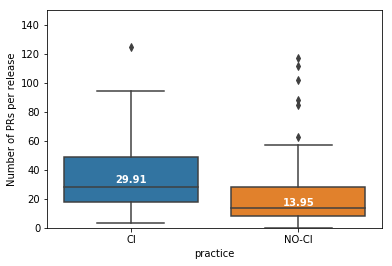

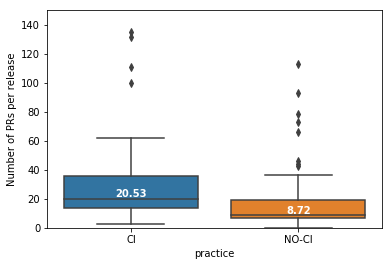

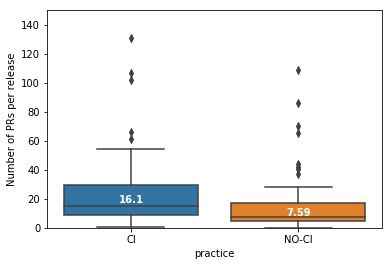

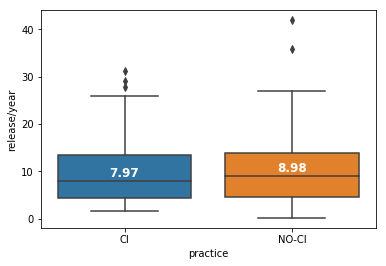

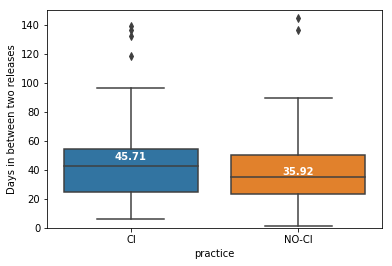

In [34]:
# analyzing projects with CI adopted 
rl_ci = pd.read_csv('./release_metadata_proj-ci.csv')
rq2_metrics(rl_ci)

created_pull_request
Median -- number of PRs per release of CI applied: 39.69385026737967
Median -- number of PRs per release of CI not applied: 27.0
0.09085191188130681 0.20918367346938777 small
****************************************************************************************************
merged_pull_request
Median -- number of PRs per release of CI applied: 30.977272727272727
Median -- number of PRs per release of CI not applied: 21.16023166023166
0.12066700981760314 0.1836734693877551 small
****************************************************************************************************
released_pull_request
Median -- number of PRs per release of CI applied: 12.319444444444445
Median -- number of PRs per release of CI not applied: 19.27027027027027
0.29433137289561484 0.08545918367346939 negligible
****************************************************************************************************
sum_submitted_PR_churn
Median -- number of PRs per release of CI applied: 234

D:\venv\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\venv\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.2859192518588676
****************************************************************************************************
duration
Median -- number of PRs per release of CI applied: 42.077338499999996
Median -- number of PRs per release of CI not applied: 26.60756137254902
0.13791720825972975 0.17091836734693877 small


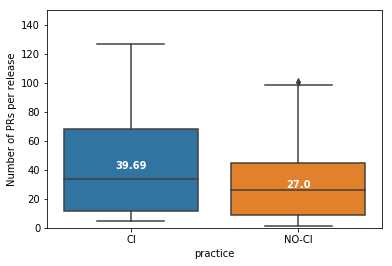

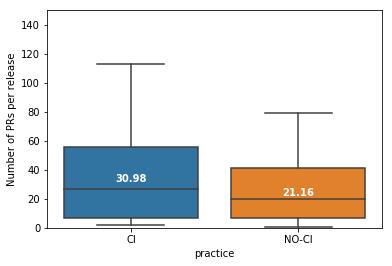

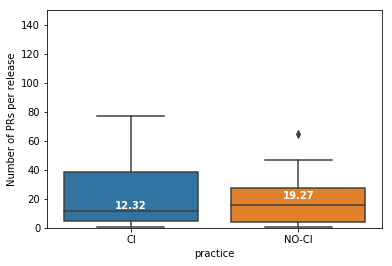

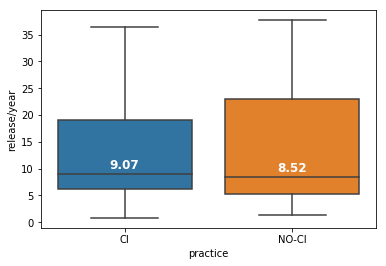

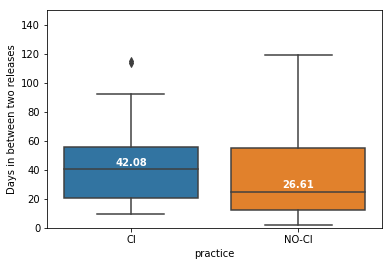

In [35]:
# analyzing projects that never applied CI 
rl_nci = pd.read_csv('./release_metadata_proj-nci.csv')
rq2_metrics(rl_nci)